In [0]:
# ✅ Load CSV
df = spark.read.csv(
    "/Volumes/travel_catalog/exam_schema/travel_volume/travel_data_sample.csv",
    header=True,
    inferSchema=True
)

print("===== Preview Data =====")
df.show(5)

print("===== Schema (Column Names + Types) =====")
df.printSchema()

print("===== Total Bookings =====")
print(df.count())

print("===== Sample Columns =====")
print(df.columns)

# 🔹 Analysis 1: Bookings per Destination
if "Destination" in df.columns:
    print("===== Bookings by Destination =====")
    df.groupBy("Destination").count().show()

# 🔹 Analysis 2: Revenue per Destination
if "Revenue" in df.columns:
    print("===== Total Revenue by Destination =====")
    df.groupBy("Destination").sum("Revenue").show()

# 🔹 Analysis 3: Customers with Most Bookings
if "CustomerID" in df.columns:
    print("===== Top 5 Customers by Booking Count =====")
    df.groupBy("CustomerID").count().orderBy("count", ascending=False).show(5)

# 🔹 Analysis 4: Trend by Booking Date (if column exists)
if "BookingDate" in df.columns:
    from pyspark.sql.functions import to_date, col, count

    df2 = df.withColumn("BookingDate", to_date(col("BookingDate"), "yyyy-MM-dd"))
    print("===== Daily Bookings Trend =====")
    df2.groupBy("BookingDate").agg(count("*").alias("Total_Bookings")).orderBy("BookingDate").show()


===== Preview Data =====
+----------+-----------+--------+---------+------------+-------------+------------+---------+------+
|booking_id|customer_id|hotel_id| location|booking_date|stay_duration|amount_spent|   status|rating|
+----------+-----------+--------+---------+------------+-------------+------------+---------+------+
|         1|      C1001|    H101|      Goa|  2024-05-20|            2|        7656|   booked|     1|
|         2|      C1002|    H105|      Goa|  2024-10-29|            4|        9040|   booked|     2|
|         3|      C1003|    H102|  Chennai|  2024-11-04|            1|        6597|   booked|     5|
|         4|      C1004|    H104|    Delhi|  2024-08-17|            5|       21390|cancelled|     1|
|         5|      C1005|    H102|Hyderabad|  2024-06-23|            3|        9819|   booked|     3|
+----------+-----------+--------+---------+------------+-------------+------------+---------+------+
only showing top 5 rows
===== Schema (Column Names + Types) =====


In [0]:
from pyspark.sql.functions import *

# Step 1: Load dataset
df = spark.read.csv(
    "/Volumes/travel_catalog/exam_schema/travel_volume/travel_data_sample.csv",
    header=True,
    inferSchema=True
)

print("===== Preview Data =====")
df.show(5)

print("===== Schema =====")
df.printSchema()


===== Preview Data =====
+----------+-----------+--------+---------+------------+-------------+------------+---------+------+
|booking_id|customer_id|hotel_id| location|booking_date|stay_duration|amount_spent|   status|rating|
+----------+-----------+--------+---------+------------+-------------+------------+---------+------+
|         1|      C1001|    H101|      Goa|  2024-05-20|            2|        7656|   booked|     1|
|         2|      C1002|    H105|      Goa|  2024-10-29|            4|        9040|   booked|     2|
|         3|      C1003|    H102|  Chennai|  2024-11-04|            1|        6597|   booked|     5|
|         4|      C1004|    H104|    Delhi|  2024-08-17|            5|       21390|cancelled|     1|
|         5|      C1005|    H102|Hyderabad|  2024-06-23|            3|        9819|   booked|     3|
+----------+-----------+--------+---------+------------+-------------+------------+---------+------+
only showing top 5 rows
===== Schema =====
root
 |-- booking_id: i

In [0]:
revenue_per_hotel = df.groupBy("hotel_id").agg(
    sum("amount_spent").alias("total_revenue")
).orderBy(desc("total_revenue"))

display(revenue_per_hotel)


hotel_id,total_revenue
H103,207194
H105,203798
H101,170233
H102,149496
H104,71130


In [0]:
avg_stay_by_location = df.groupBy("location").agg(
    avg("stay_duration").alias("avg_stay_duration")
).orderBy("location")

display(avg_stay_by_location)


location,avg_stay_duration
Chennai,2.9
Delhi,3.4285714285714284
Goa,3.8461538461538463
Hyderabad,4.916666666666667
Mumbai,3.375


In [0]:
df.createOrReplaceTempView("bookings")


In [0]:
cancellation_rate = spark.sql("""
SELECT
  hotel_id,
  SUM(CASE WHEN status = 'cancelled' THEN 1 ELSE 0 END) * 1.0 / COUNT(*) AS cancellation_rate
FROM bookings
GROUP BY hotel_id
ORDER BY cancellation_rate DESC
LIMIT 5
""")

display(cancellation_rate)


hotel_id,cancellation_rate
H104,0.4000000000000000
H101,0.3636363636363636
H102,0.2857142857142857
H103,0.1818181818181818
H105,0.1111111111111111


In [0]:
seasonal_trends = spark.sql("""
SELECT
  date_format(booking_date, 'yyyy-MM') AS month,
  location,
  SUM(amount_spent) AS total_revenue
FROM bookings
GROUP BY date_format(booking_date, 'yyyy-MM'), location
ORDER BY month, location
""")

display(seasonal_trends)


month,location,total_revenue
2024-01,Chennai,23275
2024-01,Hyderabad,16688
2024-01,Mumbai,11309
2024-02,Delhi,4706
2024-02,Goa,37846
2024-02,Hyderabad,44541
2024-03,Chennai,18966
2024-03,Delhi,20432
2024-03,Hyderabad,29509
2024-04,Delhi,28375


In [0]:
# Save outputs (single CSV each)
revenue_per_hotel.coalesce(1).write.mode("overwrite").option("header", True).csv("/Volumes/travel_catalog/exam_schema/travel_volume/output/revenue_per_hotel")
avg_stay_by_location.coalesce(1).write.mode("overwrite").option("header", True).csv("/Volumes/travel_catalog/exam_schema/travel_volume/output/avg_stay_by_location")
cancellation_rate.coalesce(1).write.mode("overwrite").option("header", True).csv("/Volumes/travel_catalog/exam_schema/travel_volume/output/cancellation_rate")
seasonal_trends.coalesce(1).write.mode("overwrite").option("header", True).csv("/Volumes/travel_catalog/exam_schema/travel_volume/output/seasonal_trends")


In [0]:
display(dbutils.fs.ls("/Volumes/travel_catalog/exam_schema/travel_volume/output/"))


path,name,size,modificationTime
dbfs:/Volumes/travel_catalog/exam_schema/travel_volume/output/avg_stay_by_location/,avg_stay_by_location/,0,1756896902992
dbfs:/Volumes/travel_catalog/exam_schema/travel_volume/output/cancellation_rate/,cancellation_rate/,0,1756896902993
dbfs:/Volumes/travel_catalog/exam_schema/travel_volume/output/revenue_per_hotel/,revenue_per_hotel/,0,1756896902993
dbfs:/Volumes/travel_catalog/exam_schema/travel_volume/output/seasonal_trends/,seasonal_trends/,0,1756896902993


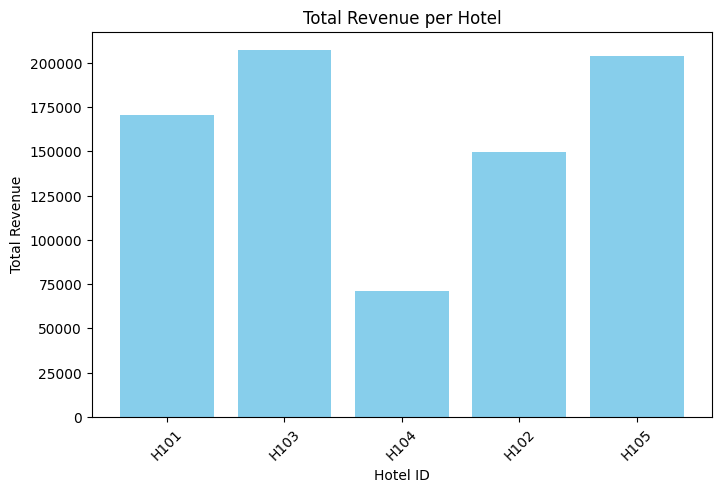

In [0]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas
rev_df = df.groupBy("hotel_id").sum("amount_spent").toPandas()

plt.figure(figsize=(8,5))
plt.bar(rev_df["hotel_id"], rev_df["sum(amount_spent)"], color="skyblue")
plt.xlabel("Hotel ID")
plt.ylabel("Total Revenue")
plt.title("Total Revenue per Hotel")
plt.xticks(rotation=45)
plt.show()


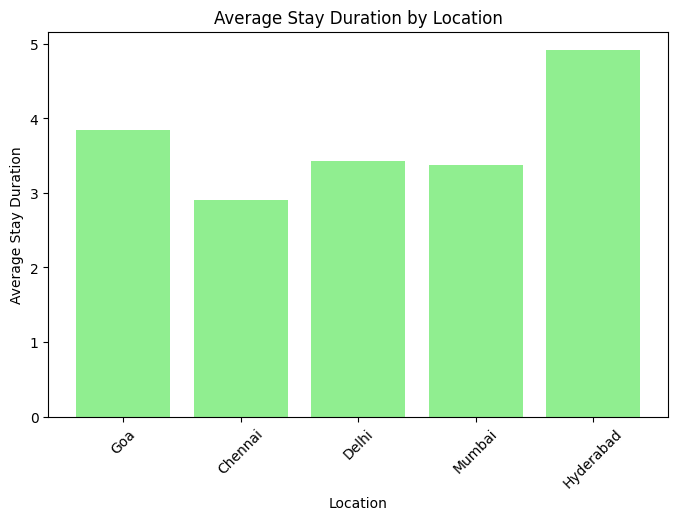

In [0]:
avg_stay_df = df.groupBy("location").avg("stay_duration").toPandas()

plt.figure(figsize=(8,5))
plt.bar(avg_stay_df["location"], avg_stay_df["avg(stay_duration)"], color="lightgreen")
plt.xlabel("Location")
plt.ylabel("Average Stay Duration")
plt.title("Average Stay Duration by Location")
plt.xticks(rotation=45)
plt.show()


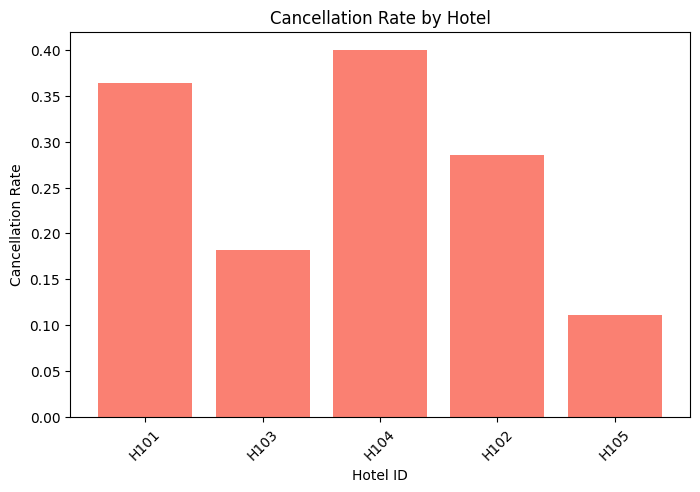

In [0]:
from pyspark.sql.functions import col, when, count

# Calculate cancellation rate
cancel_rate = (
    df.groupBy("hotel_id")
    .agg(
        (count(when(col("status")=="cancelled", 1))/count("*")).alias("cancel_rate")
    )
    .toPandas()
)

plt.figure(figsize=(8,5))
plt.bar(cancel_rate["hotel_id"], cancel_rate["cancel_rate"], color="salmon")
plt.xlabel("Hotel ID")
plt.ylabel("Cancellation Rate")
plt.title("Cancellation Rate by Hotel")
plt.xticks(rotation=45)
plt.show()


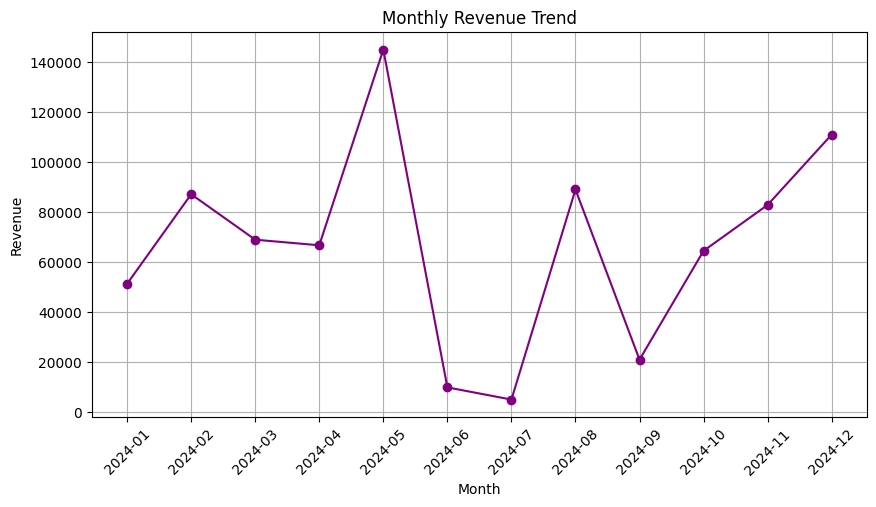

In [0]:
from pyspark.sql.functions import to_date, date_format

trend_df = (
    df.withColumn("month", date_format(to_date(col("booking_date"), "yyyy-MM-dd"), "yyyy-MM"))
    .groupBy("month")
    .sum("amount_spent")
    .orderBy("month")
    .toPandas()
)

plt.figure(figsize=(10,5))
plt.plot(trend_df["month"], trend_df["sum(amount_spent)"], marker="o", color="purple")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.title("Monthly Revenue Trend")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
